# Estudio del COVID con modelos epidemiológicos

## Índice

1. [Preparación datos](#id1)

2. [Analisis exploratorio](#id2)

3. [Modelos epidemiológicos](#id3)

4. [Modelos SIR/SEIR en Python](#id4)

5. [Ajuste least-squares](#id5)

6. [Predicción](#id6)


En este notebook vamos a ver como aplicar modelos epidemiológicos a datos de COVID-19.

Los modelos clásicos que vamos a analizar son:

* Modelo SIR (Susceptibles-Infectados-Recuperados);
* Modelo SEIR (Susceptibles-Expuestos-Infectados-Recuperados);

También vamos a proponer modificaciones para representar mejor las características presentes en la propagación del COVID-19.

Los modelos modificados son:

* Modelo SIRD (Susceptibles-Infectados-Recuperados-Muertos), que considera explícitamente la tasa de mortalidad de la enfermedad.
* Modelo SEIRD, una modificación del SEIR que tiene en cuenta el hecho de que los individuos expuestos sin síntomas pueden transmitir la enfermedad a individuos susceptibles durante el tiempo de incubación. También se  considera la subpoblación de individuos muertos.

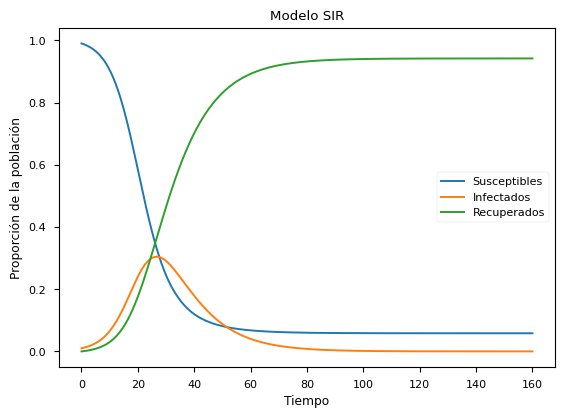

In [10]:
# Ejemplo de implementación del modelo SIR en python

# Cargamos las librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Definimos las equaciones
def sir_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# dSdt, dIdt, dRdt son las tasas de cambio de S, I y R con respecto al tiempo

# Parámetros
beta = 0.3  # Tasa de transmisión
gamma = 0.1  # Tasa de recuperación
S0, I0, R0 = 0.99, 0.01, 0  # Condiciones iniciales
t_span = (0, 160)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solución del ODE
# Resuelve el sistema de ecuaciones diferenciales definido por sir_model
solution = solve_ivp(sir_model, t_span, [S0, I0, R0], args=(beta, gamma), t_eval=t_eval)

# solution contiene la solución del sistema, incluyendo los tiempos (solution.t)
# y las soluciones para S, I y R (solution.y).

# Graficamos los resultados
plt.plot(solution.t, solution.y[0], label='Susceptibles')
plt.plot(solution.t, solution.y[1], label='Infectados')
plt.plot(solution.t, solution.y[2], label='Recuperados')
plt.xlabel('Tiempo')
plt.ylabel('Proporción de la población')
plt.legend()
plt.title('Modelo SIR')
plt.show()



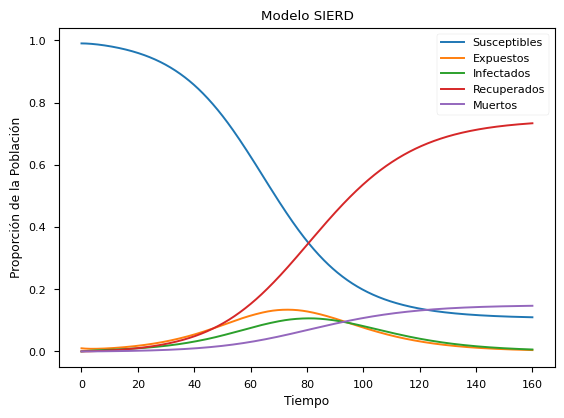

In [11]:
# Ejemplo de implementación del modelo SIERD en python

# Cargamos las librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Definimos las equaciones
def sierd_model(t, y, beta, sigma, gamma, delta):
    S, E, I, R, D = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

# Parámetros
beta = 0.3    # Tasa de transmisión
sigma = 0.1   # Tasa de progreso de expuesto a infectado
gamma = 0.1   # Tasa de recuperación
delta = 0.02  # Tasa de mortalidad
S0, E0, I0, R0, D0 = 0.99, 0.01, 0, 0, 0  # Condiciones iniciales
t_span = (0, 160)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solución del ODE
solution = solve_ivp(sierd_model, t_span, [S0, E0, I0, R0, D0], args=(beta, sigma, gamma, delta), t_eval=t_eval)

# Graficamos los resultados
plt.plot(solution.t, solution.y[0], label='Susceptibles')
plt.plot(solution.t, solution.y[1], label='Expuestos')
plt.plot(solution.t, solution.y[2], label='Infectados')
plt.plot(solution.t, solution.y[3], label='Recuperados')
plt.plot(solution.t, solution.y[4], label='Muertos')
plt.xlabel('Tiempo')
plt.ylabel('Proporción de la Población')
plt.legend()
plt.title('Modelo SIERD')
plt.show()


**Ahora vamos a usar estos modelos epidemiológicos para predecir la progresión inicial de casos de COVID a partir de los datos reales de distintos países.**

In [12]:
# Montamos la unidad Drive para acceder a los archivos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Especificamos la ruta hasta la carpeta donde tenemos los archivos de la Unidad 3
%cd /content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad3


In [13]:
# Cargamos las librerias necesarias
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp # para el ajuste y la optimización
from scipy import optimize # para el ajuste y la optimización
from numba import jit # para acelerar los procesos de optimización/ajustes

# Librerías de visualización
import matplotlib.pyplot as plt
import altair as alt

seed = 12345 # para que sea reproducible
np.random.seed(seed)

plt.style.use('seaborn-v0_8-paper') # estilo bonito de seaborn


<a id="data_prep"></a>
## Preparación de los datos

In [15]:
# Cargamos los datos
df_covid = pd.read_csv("data/covid_19_clean_complete.csv", parse_dates=['Date'])

# Mostramos la información de las variables
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18056 entries, 0 to 18055
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  8174 non-null   object        
 1   Country/Region  18056 non-null  object        
 2   Lat             18056 non-null  float64       
 3   Long            18056 non-null  float64       
 4   Date            18056 non-null  datetime64[ns]
 5   Confirmed       18056 non-null  int64         
 6   Deaths          18056 non-null  int64         
 7   Recovered       18056 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.1+ MB


<ipython-input-15-8c3371eb6943>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_covid = pd.read_csv("data/covid_19_clean_complete.csv", parse_dates=['Date'])


In [16]:
# Mostramos las primeras filas
df_covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0


In [17]:
# Nos quedamos con las columnas relevantes
columns_to_filter_cases = ["Country/Region", "Date", "Confirmed", "Deaths"]
df_covid_cases = df_covid[columns_to_filter_cases]

# Mostramos otra vez las primeras filas con el nuevo df
df_covid_cases.head()

,Country/Region,Date,Confirmed,Deaths
0,Thailand,2020-01-22,2,0
1,Japan,2020-01-22,2,0
2,Singapore,2020-01-22,0,0
3,Nepal,2020-01-22,0,0
4,Malaysia,2020-01-22,0,0


In [18]:
# Mostramos las fechas disponibles
print(f"Primer día registrado:\t {df_covid['Date'].min()}")
print(f"Último día registrado:\t {df_covid['Date'].max()}")
print(f"Total de días registrados:\t {df_covid['Date'].max() - df_covid['Date'].min()}")

Primer día registrado:	 2020-01-22 00:00:00
Último día registrado:	 2020-03-22 00:00:00
Total de días registrados:	 60 days 00:00:00


In [19]:
# Renombramos las columnas
df_covid.rename(
    columns={
        'Date': 'date',
        'Province/State':'state',
        'Country/Region':'country',
        'Last Update':'last_updated',
        'Confirmed': 'confirmed',
        'Deaths':'deaths',
        'Recovered':'recovered'},
    inplace=True
)

# Mostramos el nuevo dataset
df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
18051,NaN,Dominica,15.4150,-61.3710,2020-03-22,1,0,0
18052,NaN,Grenada,12.1165,-61.6790,2020-03-22,1,0,0
18053,NaN,Mozambique,-18.6657,35.5296,2020-03-22,1,0,0
18054,NaN,Syria,34.8021,38.9968,2020-03-22,1,0,0


Vamos a considerar que los casos activos son los casos confirmados excluyendo los muertos y las personas que se han recuperado:

`Active Case = confirmed - deaths - recovered`


In [20]:
# Creamos una columna con la información de los casos activos
df_covid['active'] = df_covid['confirmed'] - df_covid['deaths'] - df_covid['recovered']

# Mostramos el df con la nueva columna
df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,active
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0,2
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0,2
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...,...
18051,NaN,Dominica,15.4150,-61.3710,2020-03-22,1,0,0,1
18052,NaN,Grenada,12.1165,-61.6790,2020-03-22,1,0,0,1
18053,NaN,Mozambique,-18.6657,35.5296,2020-03-22,1,0,0,1
18054,NaN,Syria,34.8021,38.9968,2020-03-22,1,0,0,1


In [21]:
# Cambiamos el nombre de Mainland China a China
df_covid['country'] = df_covid['country'].replace('Mainland China', 'China')

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,active
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0,2
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0,2
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...,...
18051,NaN,Dominica,15.4150,-61.3710,2020-03-22,1,0,0,1
18052,NaN,Grenada,12.1165,-61.6790,2020-03-22,1,0,0,1
18053,NaN,Mozambique,-18.6657,35.5296,2020-03-22,1,0,0,1
18054,NaN,Syria,34.8021,38.9968,2020-03-22,1,0,0,1


## Análisis exploratorio de datos

**Escenario global (todos los países)**

In [22]:
# Agrupamos todos los datos por fecha y
# sumamos el número de casos confirmados y muertes

df_grouped = df_covid.groupby('date')[['confirmed', 'deaths']].sum().reset_index()

df_grouped

,date,confirmed,deaths
0,2020-01-22,554,17
1,2020-01-23,652,18
2,2020-01-24,939,26
3,2020-01-25,1432,42
4,2020-01-26,2113,56
...,...,...,...
56,2020-03-18,214910,8733
57,2020-03-19,242708,9867
58,2020-03-20,272166,11299
59,2020-03-21,304524,12973


In [23]:
# Mostramos de manera gráfica la evolución de los casos/muertes en el tiempo
# La librería altair nos permite crear gráficos interactivos

confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60, color='blue').encode(
    x=alt.X('date', axis=alt.Axis(title='Date')),
    y=alt.Y('confirmed', axis=alt.Axis(title='Cases'))
)

deaths_plot = alt.Chart(df_grouped).mark_circle(size=60, color='red').encode(
    x='date',
    y='deaths'
)

# Juntamos los dos gráficos en uno para compararlos mejor
worldwide_plot = confirmed_plot + deaths_plot
worldwide_plot.interactive()

alt.LayerChart(...)

Ahora vamos a crear funciones para poder mostrar estos gráficos por país.

In [24]:
# Esta función agrupa los datos del país especificado como input
def get_df_country_cases(df: pd.DataFrame, country_name: str) -> pd.DataFrame:
    df_grouped_country = df[df['country'] == country_name].reset_index()
    df_grouped_country_date = df_grouped_country.groupby('date')[['confirmed', 'deaths']].sum().reset_index()
    df_grouped_country_date["confirmed_marker"] = df_grouped_country_date.shape[0] * ['Confirmed']
    df_grouped_country_date["deaths_marker"] = df_grouped_country_date.shape[0] * ['Deaths']
    return df_grouped_country_date

In [25]:
# Esta función crea el gráfico de los casos confirmados y las muertes en el tiempo
def altair_plot_for_confirmed_and_deaths(df_grouped: pd.DataFrame, data_at_x_axis: str='date') -> alt.Chart:
    confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=alt.X(data_at_x_axis, axis=alt.Axis(title='Date')),
        y=alt.Y('confirmed', axis=alt.Axis(title='Cases'), title='Confirmed'),
        color=alt.Color("confirmed_marker", title="Cases"),
    )

    deaths_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=data_at_x_axis,
        y='deaths',
        color=alt.Color("deaths_marker"),
    )

    return confirmed_plot + deaths_plot

In [26]:
# Usamos get_df_country_cases para obtener el df de Brasil
df_grouped_brazil = get_df_country_cases(df_covid, "Brazil")

df_grouped_brazil

,date,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-22,0,0,Confirmed,Deaths
1,2020-01-23,0,0,Confirmed,Deaths
2,2020-01-24,0,0,Confirmed,Deaths
3,2020-01-25,0,0,Confirmed,Deaths
4,2020-01-26,0,0,Confirmed,Deaths
...,...,...,...,...,...
56,2020-03-18,372,3,Confirmed,Deaths
57,2020-03-19,621,6,Confirmed,Deaths
58,2020-03-20,793,11,Confirmed,Deaths
59,2020-03-21,1021,15,Confirmed,Deaths


In [27]:
# Mostramos el gráfico para Brasil
altair_plot_for_confirmed_and_deaths(df_grouped_brazil).interactive()

alt.LayerChart(...)

Vamos a ver los datos de China

In [28]:
# Creamos el dataset con los datos de China
df_grouped_china = get_df_country_cases(df_covid, "China")

df_grouped_china

,date,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-22,548,17,Confirmed,Deaths
1,2020-01-23,643,18,Confirmed,Deaths
2,2020-01-24,920,26,Confirmed,Deaths
3,2020-01-25,1406,42,Confirmed,Deaths
4,2020-01-26,2075,56,Confirmed,Deaths
...,...,...,...,...,...
56,2020-03-18,81102,3241,Confirmed,Deaths
57,2020-03-19,81156,3249,Confirmed,Deaths
58,2020-03-20,81250,3253,Confirmed,Deaths
59,2020-03-21,81305,3259,Confirmed,Deaths


In [29]:
# Mostramos el gráfico
altair_plot_for_confirmed_and_deaths(df_grouped_china).interactive()

alt.LayerChart(...)

Ahora vamos a analizar Italia

In [30]:
# Creamos el dataset con los datos de Italia
df_grouped_italy = get_df_country_cases(df_covid, "Italy")

df_grouped_italy

,date,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-22,0,0,Confirmed,Deaths
1,2020-01-23,0,0,Confirmed,Deaths
2,2020-01-24,0,0,Confirmed,Deaths
3,2020-01-25,0,0,Confirmed,Deaths
4,2020-01-26,0,0,Confirmed,Deaths
...,...,...,...,...,...
56,2020-03-18,35713,2978,Confirmed,Deaths
57,2020-03-19,41035,3405,Confirmed,Deaths
58,2020-03-20,47021,4032,Confirmed,Deaths
59,2020-03-21,53578,4825,Confirmed,Deaths


In [31]:
# Mostramos el gráfico
altair_plot_for_confirmed_and_deaths(df_grouped_italy).interactive()

alt.LayerChart(...)

### Comparación entre Brasil y Italia

In [32]:
# Nos quedamos con el dataset a partir de la fecha en la que empiezan los casos
df_brazil_cases_by_day = df_grouped_brazil[df_grouped_brazil.confirmed > 0]
df_brazil_cases_by_day = df_brazil_cases_by_day.reset_index(drop=True)

# Creamos una columna que indica el número del día (1, 2, 3, etc) des del primer caso
df_brazil_cases_by_day['day'] = df_brazil_cases_by_day.date.apply(lambda x: (x - df_brazil_cases_by_day.date.min()).days)

# Reorganizamos las columnas
reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_brazil_cases_by_day = df_brazil_cases_by_day[reordered_columns]

# Mostramos el df
df_brazil_cases_by_day.head(10)

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-02-26,0,1,0,Confirmed,Deaths
1,2020-02-27,1,1,0,Confirmed,Deaths
2,2020-02-28,2,1,0,Confirmed,Deaths
3,2020-02-29,3,2,0,Confirmed,Deaths
4,2020-03-01,4,2,0,Confirmed,Deaths
5,2020-03-02,5,2,0,Confirmed,Deaths
6,2020-03-03,6,2,0,Confirmed,Deaths
7,2020-03-04,7,4,0,Confirmed,Deaths
8,2020-03-05,8,4,0,Confirmed,Deaths
9,2020-03-06,9,13,0,Confirmed,Deaths


In [33]:
# Repetimos el proceso con Italia

# Nos quedamos con el dataset a partir de la fecha en la que empiezan los casos
df_italy_cases_by_day = df_grouped_italy[df_grouped_italy.confirmed > 0]
df_italy_cases_by_day = df_italy_cases_by_day.reset_index(drop=True)

# Creamos una columna que indica el número del día (1, 2, 3, etc) des del primer caso
df_italy_cases_by_day['day'] = df_italy_cases_by_day.date.apply(lambda x: (x - df_italy_cases_by_day.date.min()).days)

# Reorganizamos las columnas
reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_italy_cases_by_day = df_italy_cases_by_day[reordered_columns]

# Mostramos el df
df_italy_cases_by_day.head(10)

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-31,0,2,0,Confirmed,Deaths
1,2020-02-01,1,2,0,Confirmed,Deaths
2,2020-02-02,2,2,0,Confirmed,Deaths
3,2020-02-03,3,2,0,Confirmed,Deaths
4,2020-02-04,4,2,0,Confirmed,Deaths
5,2020-02-05,5,2,0,Confirmed,Deaths
6,2020-02-06,6,2,0,Confirmed,Deaths
7,2020-02-07,7,3,0,Confirmed,Deaths
8,2020-02-08,8,3,0,Confirmed,Deaths
9,2020-02-09,9,3,0,Confirmed,Deaths


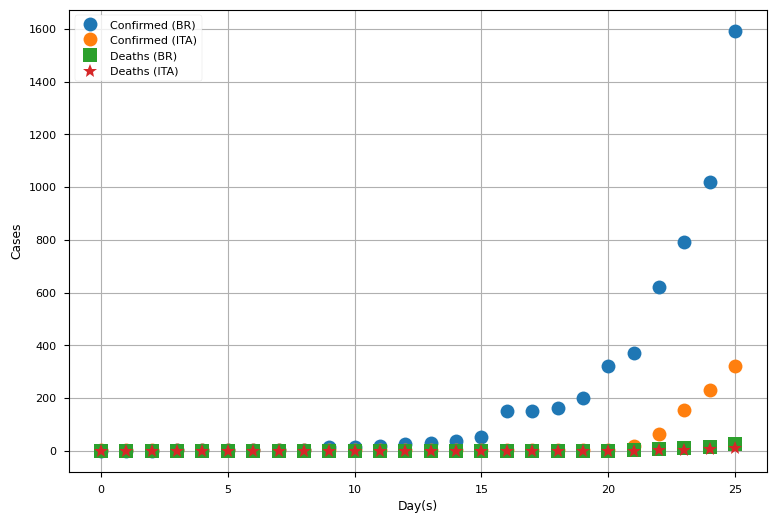

In [34]:
# Nos quedamos con el mismo número de días en los 2 datasets para poderlos comparar
df_italy_cases_by_day_limited_by_br = df_italy_cases_by_day[df_italy_cases_by_day.day <= df_brazil_cases_by_day.day.max()]
days = df_brazil_cases_by_day.day

# Mostramos el gráfico con la evolución de casos/muertes des de la detección del primer caso
plt.figure(figsize=(9, 6))
plt.plot(days, df_brazil_cases_by_day.confirmed, marker='o', linestyle="", markersize=10, label='Confirmed (BR)')
plt.plot(days, df_italy_cases_by_day_limited_by_br.confirmed, marker='o', linestyle="", markersize=10, label='Confirmed (ITA)')
plt.plot(days, df_brazil_cases_by_day.deaths, marker='s', linestyle="", markersize=10, label='Deaths (BR)')
plt.plot(days, df_italy_cases_by_day_limited_by_br.deaths, marker='*', linestyle="", markersize=10, label='Deaths (ITA)')

plt.xlabel("Day(s)")
plt.ylabel("Cases")
plt.legend()
plt.grid()

plt.show()

### China

In [35]:
# Repetimos el proceso para China

# Nos quedamos con el dataset a partir de la fecha en la que empiezan los casos
df_china_cases_by_day = df_grouped_china[df_grouped_china.confirmed > 0]
df_china_cases_by_day = df_china_cases_by_day.reset_index(drop=True)

# Creamos una columna que indica el número del día (1, 2, 3, etc) des del primer caso
df_china_cases_by_day['day'] = df_china_cases_by_day.date.apply(lambda x: (x - df_china_cases_by_day.date.min()).days)

# Reorganizamos las columnas
reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_china_cases_by_day = df_china_cases_by_day[reordered_columns]

# Mostramos el df
df_china_cases_by_day.head(10)

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-22,0,548,17,Confirmed,Deaths
1,2020-01-23,1,643,18,Confirmed,Deaths
2,2020-01-24,2,920,26,Confirmed,Deaths
3,2020-01-25,3,1406,42,Confirmed,Deaths
4,2020-01-26,4,2075,56,Confirmed,Deaths
5,2020-01-27,5,2877,82,Confirmed,Deaths
6,2020-01-28,6,5509,131,Confirmed,Deaths
7,2020-01-29,7,6087,133,Confirmed,Deaths
8,2020-01-30,8,8141,171,Confirmed,Deaths
9,2020-01-31,9,9802,213,Confirmed,Deaths


### España

In [36]:
# Repetimos el proceso para España

# Nos quedamos con el dataset a partir de la fecha en la que empiezan los casos
df_grouped_spain = get_df_country_cases(df_covid, "Spain")
df_spain_cases_by_day = df_grouped_spain[df_grouped_spain.confirmed > 0]
df_spain_cases_by_day = df_spain_cases_by_day.reset_index(drop=True)

# Creamos una columna que indica el número del día (1, 2, 3, etc) des del primer caso
df_spain_cases_by_day['day'] = df_spain_cases_by_day.date.apply(lambda x: (x - df_spain_cases_by_day.date.min()).days)

# Reorganizamos las columnas
reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_spain_cases_by_day = df_spain_cases_by_day[reordered_columns]

# Mostramos el df
df_spain_cases_by_day.head(10)

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-02-01,0,1,0,Confirmed,Deaths
1,2020-02-02,1,1,0,Confirmed,Deaths
2,2020-02-03,2,1,0,Confirmed,Deaths
3,2020-02-04,3,1,0,Confirmed,Deaths
4,2020-02-05,4,1,0,Confirmed,Deaths
5,2020-02-06,5,1,0,Confirmed,Deaths
6,2020-02-07,6,1,0,Confirmed,Deaths
7,2020-02-08,7,1,0,Confirmed,Deaths
8,2020-02-09,8,2,0,Confirmed,Deaths
9,2020-02-10,9,2,0,Confirmed,Deaths


### USA

In [37]:
# Repetimos el proceso para US

# Nos quedamos con el dataset a partir de la fecha en la que empiezan los casos
df_grouped_usa = get_df_country_cases(df_covid, "US")
df_usa_cases_by_day = df_grouped_usa[df_grouped_usa.confirmed > 0]
df_usa_cases_by_day = df_usa_cases_by_day.reset_index(drop=True)

# Creamos una columna que indica el número del día (1, 2, 3, etc) des del primer caso
df_usa_cases_by_day['day'] = df_usa_cases_by_day.date.apply(lambda x: (x - df_usa_cases_by_day.date.min()).days)

# Reorganizamos las columnas
reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_usa_cases_by_day = df_usa_cases_by_day[reordered_columns]

# Mostramos el df
df_usa_cases_by_day.head(10)

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-02-24,0,36,0,Confirmed,Deaths
1,2020-02-25,1,36,0,Confirmed,Deaths
2,2020-02-26,2,42,0,Confirmed,Deaths
3,2020-02-27,3,42,0,Confirmed,Deaths
4,2020-02-28,4,44,0,Confirmed,Deaths
5,2020-02-29,5,44,0,Confirmed,Deaths
6,2020-03-01,6,44,0,Confirmed,Deaths
7,2020-03-02,7,45,0,Confirmed,Deaths
8,2020-03-03,8,45,0,Confirmed,Deaths
9,2020-03-04,9,45,0,Confirmed,Deaths


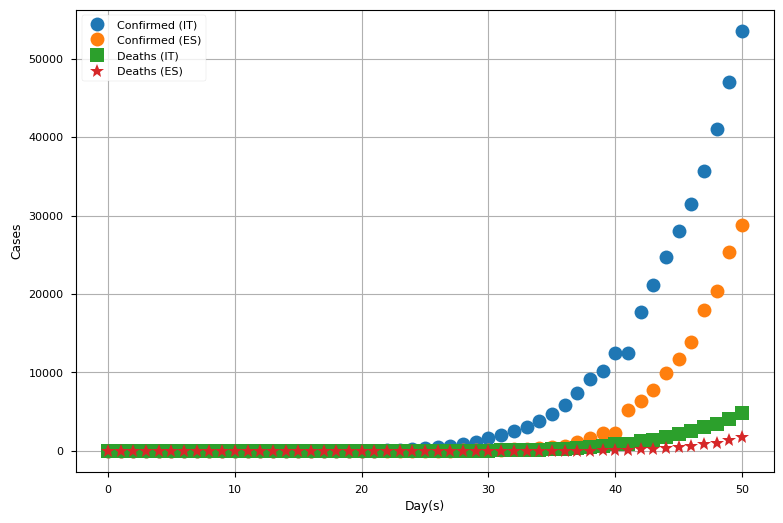

In [38]:
# Nos quedamos con el mismo número de días en los 2 datasets para poderlos comparar
df_italy_cases_by_day_limited_by_spain = df_italy_cases_by_day[df_italy_cases_by_day.day <= df_spain_cases_by_day.day.max()]
days = df_spain_cases_by_day.day

# Mostramos el gráfico con la evolución de casos/muertes des de la detección del primer caso
plt.figure(figsize=(9, 6))
plt.plot(days, df_italy_cases_by_day_limited_by_spain.confirmed, marker='o', linestyle="", markersize=10, label='Confirmed (IT)')
plt.plot(days, df_spain_cases_by_day.confirmed, marker='o', linestyle="", markersize=10, label='Confirmed (ES)')
plt.plot(days, df_italy_cases_by_day_limited_by_spain.deaths, marker='s', linestyle="", markersize=10, label='Deaths (IT)')
plt.plot(days, df_spain_cases_by_day.deaths, marker='*', linestyle="", markersize=10, label='Deaths (ES)')

plt.xlabel("Day(s)")
plt.ylabel("Cases")
plt.legend()
plt.grid()

plt.show()

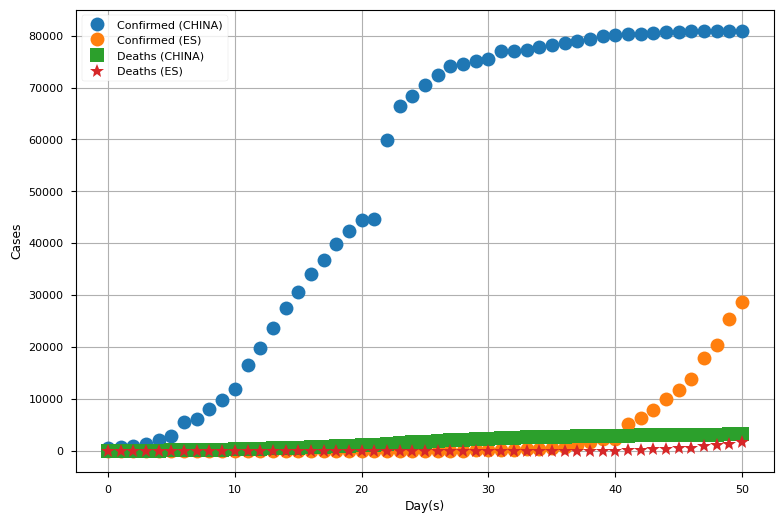

In [39]:
# Nos quedamos con el mismo número de días en los 2 datasets para poderlos comparar
df_china_cases_by_day_limited_by_spain = df_china_cases_by_day[df_china_cases_by_day.day <= df_spain_cases_by_day.day.max()]
days = df_spain_cases_by_day.day

# Mostramos el gráfico con la evolución de casos/muertes des de la detección del primer caso
plt.figure(figsize=(9, 6))
plt.plot(days, df_china_cases_by_day_limited_by_spain.confirmed, marker='o', linestyle="", markersize=10, label='Confirmed (CHINA)')
plt.plot(days, df_spain_cases_by_day.confirmed, marker='o', linestyle="", markersize=10, label='Confirmed (ES)')
plt.plot(days, df_china_cases_by_day_limited_by_spain.deaths, marker='s', linestyle="", markersize=10, label='Deaths (CHINA)')
plt.plot(days, df_spain_cases_by_day.deaths, marker='*', linestyle="", markersize=10, label='Deaths (ES)')

plt.xlabel("Day(s)")
plt.ylabel("Cases")
plt.legend()
plt.grid()

plt.show()

## Modelos epidemiológicos

Ahora, vamos a explorar los datos para calibrar un modelo epidemiológico con el objetivo de intentar simular y predecir casos.

### Modelos clásicos

#### Modelo SIR

El modelo representa un escenario epidémico, con el objetivo de predecir y controlar enfermedades infecciosas. Consiste en un sistema dinámico no lineal, que considera subgrupos poblacionales según el estado de los individuos. Un modelo simple estaría compuesto por 3 subgrupos:

* Individuos susceptibles (S);
* Infectados (I);
* Recuperados (R).

Con estos componentes, se forma un sistema dinámico clásico conocido como modelo SIR. Las ecuaciones de dicho sistema se escriben como:

\begin{align*}
  \dot{S} &= - \beta S I \\
  \dot{I} &= \beta S I - \zeta I \\
  \dot{R} &= \zeta I
\end{align*}

donde $\dot{(\bullet)}$ representa la derivada con respecto al tiempo.

Alguna explicación biológica para los parámetros:

* $\beta$ es el parámetro de conversión debido a la interacción entre un individuo susceptible y uno infectado. Es la probabilidad de que un individuo susceptible se infecte al contactar con un individuo infectado (Tasa de transmisión del virus).
* $\zeta$ es el parámetro de conversión relacionado con la tasa de recuperación. En otras palabras, los individuos que se vuelven inmunes. Es la probabilidad de que un individuo infectado se recupere y se mueva al estado R (Tasa de recuperación).

#### Modelo SEIR

Otro modelo clásico conocido como SEIR (Susceptible-Exposed-Infected-Recovered) se aplica comúnmente en la literatura de Epidemiología Computacional (puede consultarlo en otros lugares). En este modelo, se considera un nuevo subgrupo de individuos: los expuestos. Estos individuos son aquellos que están infectados, pero no muestran ningún síntoma. En el modelo clásico SEIR, los individuos expuestos **no transmiten la enfermedad**. Las equaciones ahora se convierten en:

\begin{align*}
    \dot{S} &= - \beta S  I \\
    \dot{E} &= \beta S I - \alpha E \\
    \dot{I} &= \alpha E - \zeta I \\
    \dot{R} &= \zeta I \\
\end{align*}

Breve interpretación biológica del parámetro adicional:

* $\alpha$ es el parámetro de conversión para los individuos expuestos que se transforman en infectados.

### Modelos modificados

A continuación mostramos modelos modificados para mejorar la representación de la epidemia de COVID-19.

#### Modelo SIR modificado (SIRD)

En este modelo, las muertes debido a la enfermedad se consideran explícitamente. Se introduce un nuevo subgrupo de individuos: los individuos muertos. Para considerar tal fenómeno, se requiere una ecuación adicional, así como una modificación en el balance de la ecuación de infectados. El sistema de equaciones es el siguiente

\begin{align*}
  \dot{S} &= - \beta S I \\
  \dot{I} &= \beta S I - \zeta I - \delta I \\
  \dot{R} &= \zeta I \\
  \dot{D} &= \delta I
\end{align*}

Breve interpretación biológica del parámetro adicional:

* $\delta$ es la tasa de mortalidad de la enfermedad. Es la probabilidad de que un individuo infectado muera.

#### Modelo SEIR modificado considerando muertes (SEIRD)

Este modelo tiene como objetivo resolver la carencia del modelo SEIR original, que no considera la transmisión de la enfermedad entre individuos expuestos y susceptibles. También considera una subpoblación de individuos muertos debido a la enfermedad. Así, el modelo se escribe como:

\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E \\
    \dot{E} &= \beta S I - \alpha E + \gamma S E \\
    \dot{I} &= \alpha E - \zeta I - \delta I \\
    \dot{R} &= \zeta I \\
    \dot{D} &= \delta I
\end{align*}

* $\gamma$ es el parámetro de la tasa de conversión para los individuos susceptibles que interactúan con individuos expuestos y luego se vuelven expuestos.

### Comentario adicional sobre las unidades

Todas las variables de subpoblación (S, I, R, etc.) son adimensionales. Para obtener las variables, tenemos que considerar que

\begin{align*}
    &S := \frac{{S}}{N} \\
    &E := \frac{{E}}{N} \\
    &I := \frac{{I}}{N} \\
    &R := \frac{{R}}{N} \\
    &D := \frac{{D}}{N} \\
\end{align*}

con $N$ denotando la población total y ${S}$, ${E}$, ${I}$, ${R}$ y ${D}$ como las cantidades absolutas de subpoblación. Por lo tanto, S, E, I, R y D se dan como fracciones de la población total.

## Modelos SIRD/SEIRD en Python

In [40]:
@jit(nopython=True)
def sird_model(t, X, beta=1, delta=0.02, zeta=1/15):
    """
    Modelo SIR que tiene en cuenta el número de muertes.
    """
    S, I, R, D = X
    S_prime = - beta * S * I # los susceptibles disminuyen a medida que se infectan
    I_prime = beta * S * I - zeta * I - delta * I # los infectados disminuyen según se van recuperando o muriendo
    R_prime = zeta * I
    D_prime = delta * I
    return S_prime, I_prime, R_prime, D_prime


@jit(nopython=True)
def seird_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    Este es un modelo SEIR modificado para tener en cuenta el tiempo de incubación
    en individuos expuestos y las muertes.
    Los individuos expuestos pueden transmitir la infección a individuos susceptibles.
    """
    S, E, I, R, D = X
    S_prime = - beta * S * I - gamma * E * S  # los susceptibles disminuyen a medida que se exponen
    E_prime = beta * S * I - alpha * E + gamma * E * S # los expuestos disminuyen a medida que se infectan
    I_prime = alpha * E - zeta * I - delta * I # los infectados disminuyen según se van recuperando
    R_prime = zeta * I
    D_prime = delta * I # se consideran también los muertos
    return S_prime, E_prime, I_prime, R_prime, D_prime



Para resolver ecuaciones diferenciales ordinarias vamos a usar unos algoritmos informáticos llamados ODE solvers.

Las ecuaciones diferenciales ordinarias describen cómo cambian las variables a lo largo del tiempo, dadas ciertas condiciones iniciales y parámetros. Los ODE solvers utilizan métodos numéricos para aproximar la solución de estas ecuaciones en intervalos discretos de tiempo. Podéis encontrar más información de como funciona solve_ivp en este [link](https://medium.com/@bldevries/simply-solving-differential-equations-using-python-scipy-and-solve-ivp-f6185da2572d).

Ahora definimos los ODE solvers de `scipy.integrate.solve_ivp` con unos parámetros iniciales, pero posteriormente vamos a usar un algoritmo de optimización para encontrar el valor óptimo de estos parámetros.

In [41]:
# Definimos las funciones para resolver las equaciones diferenciales
# según el tipo de modelo

def sird_ode_solver(y0, t_span, t_eval, beta=1, delta=0.02, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: sird_model(t, y, beta=beta, zeta=zeta, delta=delta),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )

    return solution_ODE


def seird_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, delta=0.02, alpha=1/4, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seird_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )

    return solution_ODE

Es importante saber la población de cada país ya que afectará a la cantidad de gente susceptible de infectarse.

In [42]:
# Cargamos la información del dataset
df_population = pd.read_csv("data/countries of the world.csv")

# Mostramos las primeras filas
df_population.head(5)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [43]:
# Vamos a seleccionar la población de los países que estábamos analizando
brazil_population = float(df_population[df_population.Country == 'Brazil '].Population)
italy_population = float(df_population[df_population.Country == 'Italy '].Population)
china_population = float(df_population[df_population.Country == 'China '].Population)
spain_population = float(df_population[df_population.Country == 'Spain '].Population)
us_population = float(df_population[df_population.Country == 'United States '].Population)

# Vamos a usar los datos de España para hacer el análsis
target_population = spain_population
print("Población de España: ",target_population)

Población de España:  40397842.0


<ipython-input-43-29cfdd48fd65>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  brazil_population = float(df_population[df_population.Country == 'Brazil '].Population)
<ipython-input-43-29cfdd48fd65>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  italy_population = float(df_population[df_population.Country == 'Italy '].Population)
<ipython-input-43-29cfdd48fd65>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  china_population = float(df_population[df_population.Country == 'China '].Population)
<ipython-input-43-29cfdd48fd65>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spain_population = f

Por lo tanto, se pueden definir las siguientes condiciones iniciales:

- Vamos a suponer que toda la población de España es susceptible (S).
- La población expuesta es mayor que los casos reportados, suponemos en un factor 5 (E0=5*I0).
- Los infectados son los casos reportados.
- En la situación inicial no hay ni muertos ni recuperados.

In [44]:
# Definimos las condiciones especificadas
df_target_country = df_spain_cases_by_day
S0, E0, I0, R0, D0 = target_population, 5 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), 0., 0.

# Basándonos en las equaciones de cada modelo, definimos la y0 (valor situación inicial)
y0_sird = S0 / target_population, I0 / target_population, R0, D0  # SIRD
y0_seird = S0 / target_population, E0 / target_population, I0 / target_population, R0, D0  # SEIRD

In [45]:
# Mostramos el valor inicial de los parámetros del modelo SIRD
# S0, I0, R0, D0
print(y0_sird)

(1.0, 2.4753797492450214e-08, 0.0, 0.0)


In [46]:
# Mostramos el valor inicial de los parámetros del modelo SEIRD
# S0, E0, I0, R0, D0
print(y0_seird)

(1.0, 1.2376898746225109e-07, 2.4753797492450214e-08, 0.0, 0.0)


Podemos seleccionar los modelos a mostrar

In [47]:

has_to_run_sird = True
has_to_run_seird = True

## Ajuste del modelo

Para poder estimar los parámetros óptimos, vamos a ajustar el modelo con un método de mínimos cuadrados no lineal.

Esta función calcula el error cuadrático medio entre los datos observados y los datos simulados por los distintos modelos (por ejemplo el modelo SIR). Así pues, proporciona una medida de qué tan bien los parámetros actuales del modelo ajustan los datos observados.

Este error se utilizará posteriormente en un algoritmo de optimización para ajustar los parámetros del modelo de manera que minimicen la discrepancia entre los datos simulados y observados.

In [48]:

def sird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution

    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def seird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution

    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def callback_de(xk, convergence):
    print(f'parameters = {xk}')

Establecemos el dominio de ajuste (tiempo dado para cada observación) y las observaciones (población observada en un momento dado):

In [49]:
# tiempo de cada observación
data_time = df_target_country.day.values.astype(np.float64)
# ratio de personas infectadas vs población total
infected_individuals = df_target_country.confirmed.values / target_population
# ratio de personas muertas vs población total
dead_individuals = df_target_country.deaths.values / target_population

Para encontrar los parámetros que se ajustan mejor a los datos, vamos a usar un método de optimización. Hay muchos algoritmos que se pueden usar, pero en este caso, para evitar mínimos locales, vamos a usar el método de Evolución Diferencial (DE).

**Nota**: Consulta esta [presentación](https://www.maths.uq.edu.au/MASCOS/Multi-Agent04/Fleetwood.pdf) para saber más sobre este tema.


La función `differential_evolution` del módulo `optimize` de SciPy se usa para minimizar la función de error en un problema de optimización basado en los distintos modelos epidemiológicos.

In [50]:
if has_to_run_sird:
  # Define los límites para los parámetros a optimizar.
    bounds_sird = [(0, 1), (0, 0.2)]
    # optimize.differential_evolution realizar la optimización evolutiva diferencial
    result_sird = optimize.differential_evolution(
        # sird_least_squares_error_ode es la función objetivo que se va a minimizar.
        # Calcula el error entre los datos observados y los datos modelados.
        sird_least_squares_error_ode,
        # Límites para los parámetros de la función a optimizar
        bounds=bounds_sird,
        # Proporciona argumentos adicionales para la función objetivo
        # data_time: Tiempos en los que se han observado datos.
        # infected_individuals: Datos observados de individuos infectados.
        # sir_ode_solver: Función que resuelve las ecuaciones diferenciales del modelo SIRD.
        # y0_sir: Condiciones iniciales para el solver del modelo SIRD.
        args=(data_time, [infected_individuals, dead_individuals], sird_ode_solver, y0_sird),
        # Tamaño de la población para el algoritmo evolutivo.
        popsize=300,
        # Especifica la estrategia de evolución diferencia
        strategy='best1bin',
        # Establece la tolerancia para la convergencia
        tol=1e-2,
        # El parámetro de recombinación que controla la mezcla de soluciones de la población.
        recombination=0.5,
        # Máximo de iteraciones del algoritmo
        maxiter=100,
        # Opciones de mensaje, reproducidad, CPUs
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_sird)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentialevolution.py:488: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 3.3664859495390973e-08
parameters = [0.29964642 0.02837216]
differential_evolution step 2: f(x)= 1.2908878981507614e-08
parameters = [0.28808    0.01555023]
differential_evolution step 3: f(x)= 1.2908878981507614e-08
parameters = [0.28808    0.01555023]
differential_evolution step 4: f(x)= 1.2908878981507614e-08
parameters = [0.28808    0.01555023]
differential_evolution step 5: f(x)= 1.2658544488765954e-08
parameters = [0.29049887 0.01718667]
differential_evolution step 6: f(x)= 1.0804455166735818e-08
parameters = [0.28515856 0.01219161]
differential_evolution step 7: f(x)= 1.0804455166735818e-08
parameters = [0.28515856 0.01219161]
differential_evolution step 8: f(x)= 1.0804455166735818e-08
parameters = [0.28515856 0.01219161]
differential_evolution step 9: f(x)= 1.0804455166735818e-08
parameters = [0.28515856 0.01219161]
differential_evolution step 10: f(x)= 1.0804455166735818e-08
parameters = [0.28515856 0.01219161]
differential_evolution step 1

In [51]:
if has_to_run_seird:
    bounds_seird = [(0, 1), (0, 1), (0, 0.2)]
    result_seird = optimize.differential_evolution(
        seird_least_squares_error_ode,
        bounds=bounds_seird,
        args=(data_time, [infected_individuals, dead_individuals], seird_ode_solver, y0_seird),
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seird)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentialevolution.py:488: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 3.068827570396181e-08
parameters = [0.40218448 0.06701563 0.02204153]
differential_evolution step 2: f(x)= 2.8246201114815192e-08
parameters = [0.13403658 0.29936465 0.01890976]
differential_evolution step 3: f(x)= 2.8246201114815192e-08
parameters = [0.13403658 0.29936465 0.01890976]
differential_evolution step 4: f(x)= 2.8246201114815192e-08
parameters = [0.13403658 0.29936465 0.01890976]
differential_evolution step 5: f(x)= 1.876963016945263e-08
parameters = [0.21243214 0.22803473 0.01325908]
differential_evolution step 6: f(x)= 1.876963016945263e-08
parameters = [0.21243214 0.22803473 0.01325908]
differential_evolution step 7: f(x)= 1.876963016945263e-08
parameters = [0.21243214 0.22803473 0.01325908]
differential_evolution step 8: f(x)= 1.6479107482162427e-08
parameters = [0.29928397 0.14791034 0.01113113]
differential_evolution step 9: f(x)= 1.6479107482162427e-08
parameters = [0.29928397 0.14791034 0.01113113]
differential_evolution step 10: 

In [52]:
zeta_fitted = 1/14  # Tasa de recuperación --> el inverso es igual a la cantidad de días necesarios para recuperarse de la enfermedad.
if has_to_run_sird:
    beta_fitted_sird, delta_fitted_sird = result_sird.x  # parámetros SIRD

alpha_fitted = 1/4 # Tasa de infección
if has_to_run_seird:
    beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird = result_seird.x  # parámetros SEIRD


Ahora que ya tenemos los parámetros óptimos del modelo, vamos a usar el ode_solver para simular la evolución de cada modelo en un intervalo de tiempo dado.

In [53]:
# Resolvemos las equaciones diferenciales y ajustamos según el modelo seleccionado
t0 = data_time.min()
tf = data_time.max()

if has_to_run_sird:
    solution_ODE_sird = sird_ode_solver(
        y0_sird, (t0, tf), data_time, beta_fitted_sird, delta_fitted_sird, zeta_fitted
        )  # SIRD
    t_computed_sird, y_computed_sird = solution_ODE_sird.t, solution_ODE_sird.y
    S_sird, I_sird, R_sird, D_sird = y_computed_sird

if has_to_run_seird:
    solution_ODE_seird = seird_ode_solver(
        y0_seird, (t0, tf), data_time, beta_fitted_seird, gamma_fitted_seird,
        delta_fitted_seird, alpha_fitted, zeta_fitted
        )  # SEIRD
    t_computed_seird, y_computed_seird = solution_ODE_seird.t, solution_ODE_seird.y
    S_seird, E_seird, I_seird, R_seird, D_seird = y_computed_seird

In [54]:
# Recogemos la información de los parámetros de cada modelo en forma de diccionario
model_list = list()
alpha_list = list()
beta_list = list()
delta_list = list()
gamma_list = list()
zeta_list = list()

if has_to_run_sird:
    model_list.append("SIRD")
    alpha_list.append("-")
    beta_list.append(beta_fitted_sird)
    delta_list.append(delta_fitted_sird)
    gamma_list.append("-")
    zeta_list.append(zeta_fitted)

if has_to_run_seird:
    model_list.append("SEIRD")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seird)
    delta_list.append(delta_fitted_seird)
    gamma_list.append(gamma_fitted_seird)
    zeta_list.append(zeta_fitted)


parameters_dict = {
    "Model": model_list,
    r"$\alpha$": alpha_list,
    r"$\beta$": beta_list,
    r"$\delta$": delta_list,
    r"$\gamma$": gamma_list,
    r"$\zeta$": zeta_list,
}

# Creamos un df con la información de los diccionarios
df_parameters_calibrated = pd.DataFrame(parameters_dict)

# Mostramos el valor de los parámetros de cada modelo
df_parameters_calibrated

,Model,$\alpha$,$\beta$,$\delta$,$\gamma$,$\zeta$
0,SIRD,-,0.283701,0.010571,-,0.071429
1,SEIRD,0.25,0.377320,0.009603,0.075799,0.071429


Mostramos las simulaciones por cada modelo:

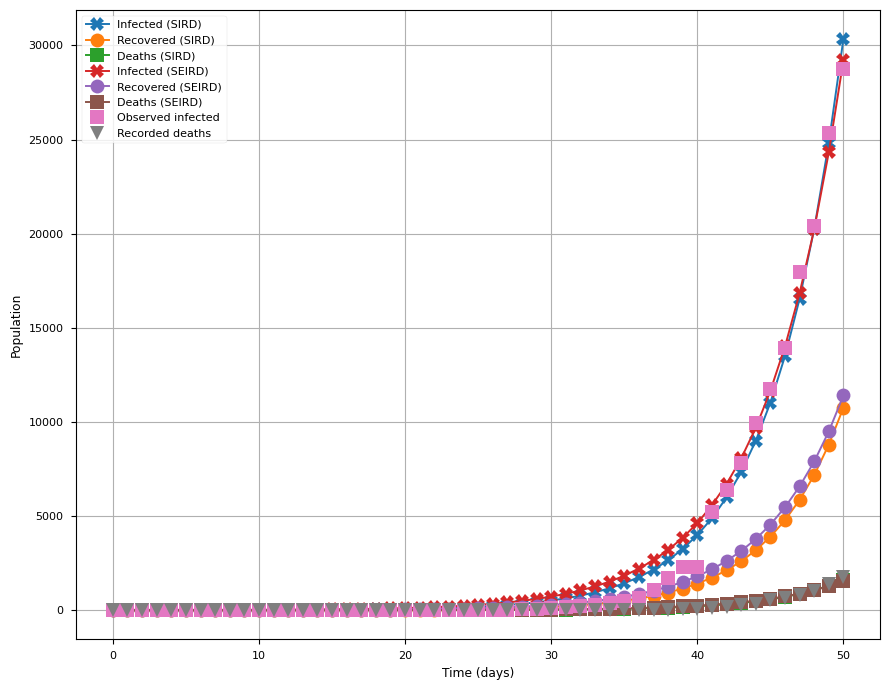

In [55]:
plt.figure(figsize=(9,7))

if has_to_run_sird:
    plt.plot(t_computed_sird, I_sird * target_population, label='Infected (SIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, R_sird * target_population, label='Recovered (SIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, D_sird * target_population, label='Deaths (SIRD)', marker='s', linestyle="-", markersize=10)

if has_to_run_seird:
    plt.plot(t_computed_seird, I_seird * target_population, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, R_seird * target_population, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, D_seird * target_population, label='Deaths (SEIRD)', marker='s', linestyle="-", markersize=10)

plt.plot(data_time, infected_individuals * target_population, label='Observed infected', marker='s', linestyle="", markersize=10)
plt.plot(data_time, dead_individuals * target_population, label='Recorded deaths', marker='v', linestyle="", markersize=10)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Population')

plt.tight_layout()
plt.savefig("all_deterministic_calibration.png")
plt.show()

In [56]:
# Mostramos el valor de muertes en el último día estimado con los modelos.
methods_list = list()
deaths_list = list()
if has_to_run_sird:
    methods_list.append("SIRD")
    deaths_list.append(int(D_sird.max() * target_population))
    print(f"Muertes estimadas para el último día (SIRD):\t{int(D_sird.max() * target_population)}")

if has_to_run_seird:
    methods_list.append("SEIRD")
    deaths_list.append(int(D_seird.max() * target_population))
    print(f"Muertes estimadas para el último día (SEIRD):\t{int(D_seird.max() * target_population)}")

methods_list.append("Registrado")
deaths_list.append(int(dead_individuals[-1] * target_population))

death_estimates_dict = {"Method": methods_list, "Deaths estimate": deaths_list}
df_deaths_estimates = pd.DataFrame(death_estimates_dict)
print(f"Muertes registradas hasta el último día:\t{int(dead_individuals[-1] * target_population)}")

Muertes estimadas para el último día (SIRD):	1592
Muertes estimadas para el último día (SEIRD):	1534
Muertes registradas hasta el último día:	1772



## Predicciones

Ahora vamos a predecir para los siguientes días:

In [57]:
# t0 será el primer día
t0 = float(data_time.min())
# Vamos a simular los siguientes 90 días
number_of_days_after_last_record = 90
tf = data_time.max() + number_of_days_after_last_record
# El rango va de t0 a t0+90
time_range = np.linspace(0., tf, int(tf))

# Usamos el ode_solver para obtener los valores de S, E, I, R, D según el día
if has_to_run_sird:
    solution_ODE_predict_sird = sird_ode_solver(
        y0_sird, (t0, tf), time_range, beta_fitted_sird, delta_fitted_sird, zeta_fitted
        )  # SIR
    t_computed_predict_sird, y_computed_predict_sird = solution_ODE_predict_sird.t, solution_ODE_predict_sird.y
    S_predict_sird, I_predict_sird, R_predict_sird, D_predict_sird = y_computed_predict_sird

if has_to_run_seird:
    solution_ODE_predict_seird = seird_ode_solver(
        y0_seird, (t0, tf), time_range, beta_fitted_seird, gamma_fitted_seird,
        delta_fitted_seird, alpha_fitted, zeta_fitted
        )  # SEIRD
    t_computed_predict_seird, y_computed_predict_seird = solution_ODE_predict_seird.t, solution_ODE_predict_seird.y
    S_predict_seird, E_predict_seird, I_predict_seird, R_predict_seird, D_predict_seird = y_computed_predict_seird

Podemos calcular también en qué día habrá el pico de casos según cada modelo.

In [58]:
has_to_plot_infection_peak = True
if has_to_run_sird:
    crisis_day_sird = np.argmax(I_predict_sird)
if has_to_run_seird:
    crisis_day_seird = np.argmax(I_predict_seird)

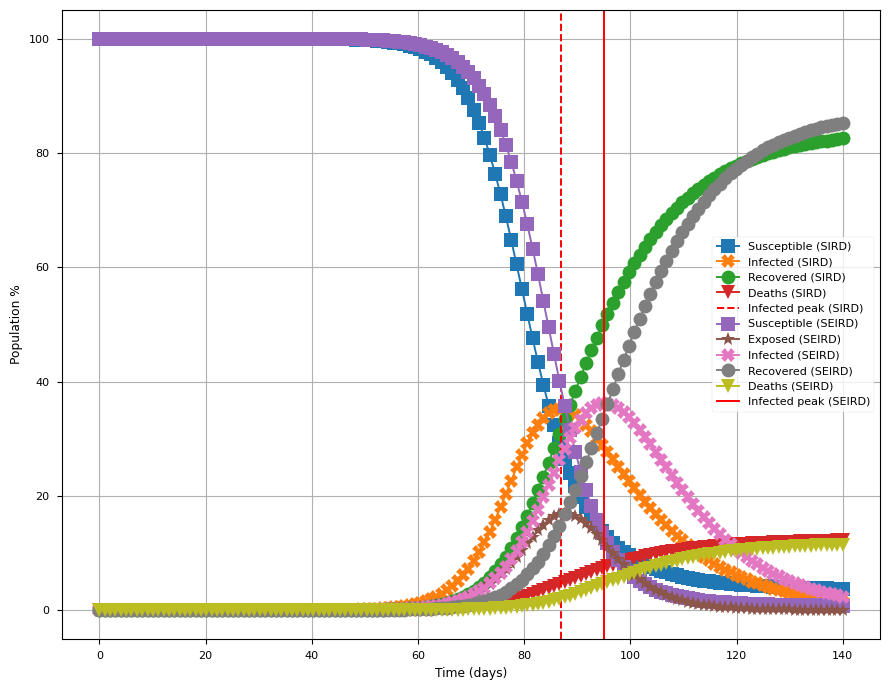

In [59]:
plt.figure(figsize=(9,7))

if has_to_run_sird:
    plt.plot(t_computed_predict_sird, 100 * S_predict_sird, label='Susceptible (SIRD)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sird, 100 * I_predict_sird, label='Infected (SIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sird, 100 * R_predict_sird, label='Recovered (SIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_sird, 100 * D_predict_sird, label='Deaths (SIRD)', marker='v', linestyle="-", markersize=10)
    if has_to_plot_infection_peak:
        plt.axvline(x=crisis_day_sird + 1, color="red", linestyle="--", label="Infected peak (SIRD)")

if has_to_run_seird:
    plt.plot(t_computed_predict_seird, 100 * S_predict_seird, label='Susceptible (SEIRD)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * E_predict_seird, label='Exposed (SEIRD)', marker='*', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * I_predict_seird, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * R_predict_seird, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_predict_seird, 100 * D_predict_seird, label='Deaths (SEIRD)', marker='v', linestyle="-", markersize=10)
    if has_to_plot_infection_peak:
        plt.axvline(x=crisis_day_seird + 1, color="red", label="Infected peak (SEIRD)")


plt.xlabel('Time (days)')
plt.ylabel('Population %')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("seir_deterministic_predictions.png")
plt.show()

In [60]:
if has_to_run_sird:
    print(f"Número máximo de personas infectadas (SIRD):\t {int(np.max(I_predict_sird) * target_population)}")
    print(f"Porcentaje de población del número máximo de personas infectadas (SIRD):\t {np.max(I_predict_sird) * 100:.2f}%")
    print(f"Estimación del día con el número máximo de personas infectadas (SIRD):\t {crisis_day_sird + 1}")
    print(f"Porcentaje del número de muertes estimado (SIRD):\t {100 * D_predict_sird[-1]:.3f}%")
    print(f"Número de muertes estimadas (SIRD):\t {target_population * D_predict_sird[-1]:.3f}")
    print("")

if has_to_run_seird:
    print(f"Número máximo de personas infectadas (SEIRD):\t {int(np.max(I_predict_seird) * target_population)}")
    print(f"Porcentaje de población del número máximo de personas infectadas (SEIRD):\t {np.max(I_predict_seird) * 100:.2f}%")
    print(f"Estimación del día con el número máximo de personas infectadas (SEIRD):\t {crisis_day_seird + 1}")
    print(f"Porcentaje del número de muertes estimado (SEIRD):\t {100 * D_predict_seird[-1]:.3f}%")
    print(f"Número de muertes estimadas (SEIRD):\t {target_population * D_predict_seird[-1]:.3f}")
    print("")

Número máximo de personas infectadas (SIRD):	 14231737
Porcentaje de población del número máximo de personas infectadas (SIRD):	 35.23%
Estimación del día con el número máximo de personas infectadas (SIRD):	 87
Porcentaje del número de muertes estimado (SIRD):	 12.214%
Número de muertes estimadas (SIRD):	 4934039.587

Número máximo de personas infectadas (SEIRD):	 14618788
Porcentaje de población del número máximo de personas infectadas (SEIRD):	 36.19%
Estimación del día con el número máximo de personas infectadas (SEIRD):	 95
Porcentaje del número de muertes estimado (SEIRD):	 11.465%
Número de muertes estimadas (SEIRD):	 4631427.638

